In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
torch.cuda.is_available()

True

In [5]:
valid_ratio = 0.2
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                               ])



trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_ratio*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Data samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler, batch_size=64, shuffle=False)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sampler, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle = False)

In [6]:
#len(testset)

In [7]:
dataiter = iter(trainloader)
images, label = dataiter.next()
images = images.numpy()

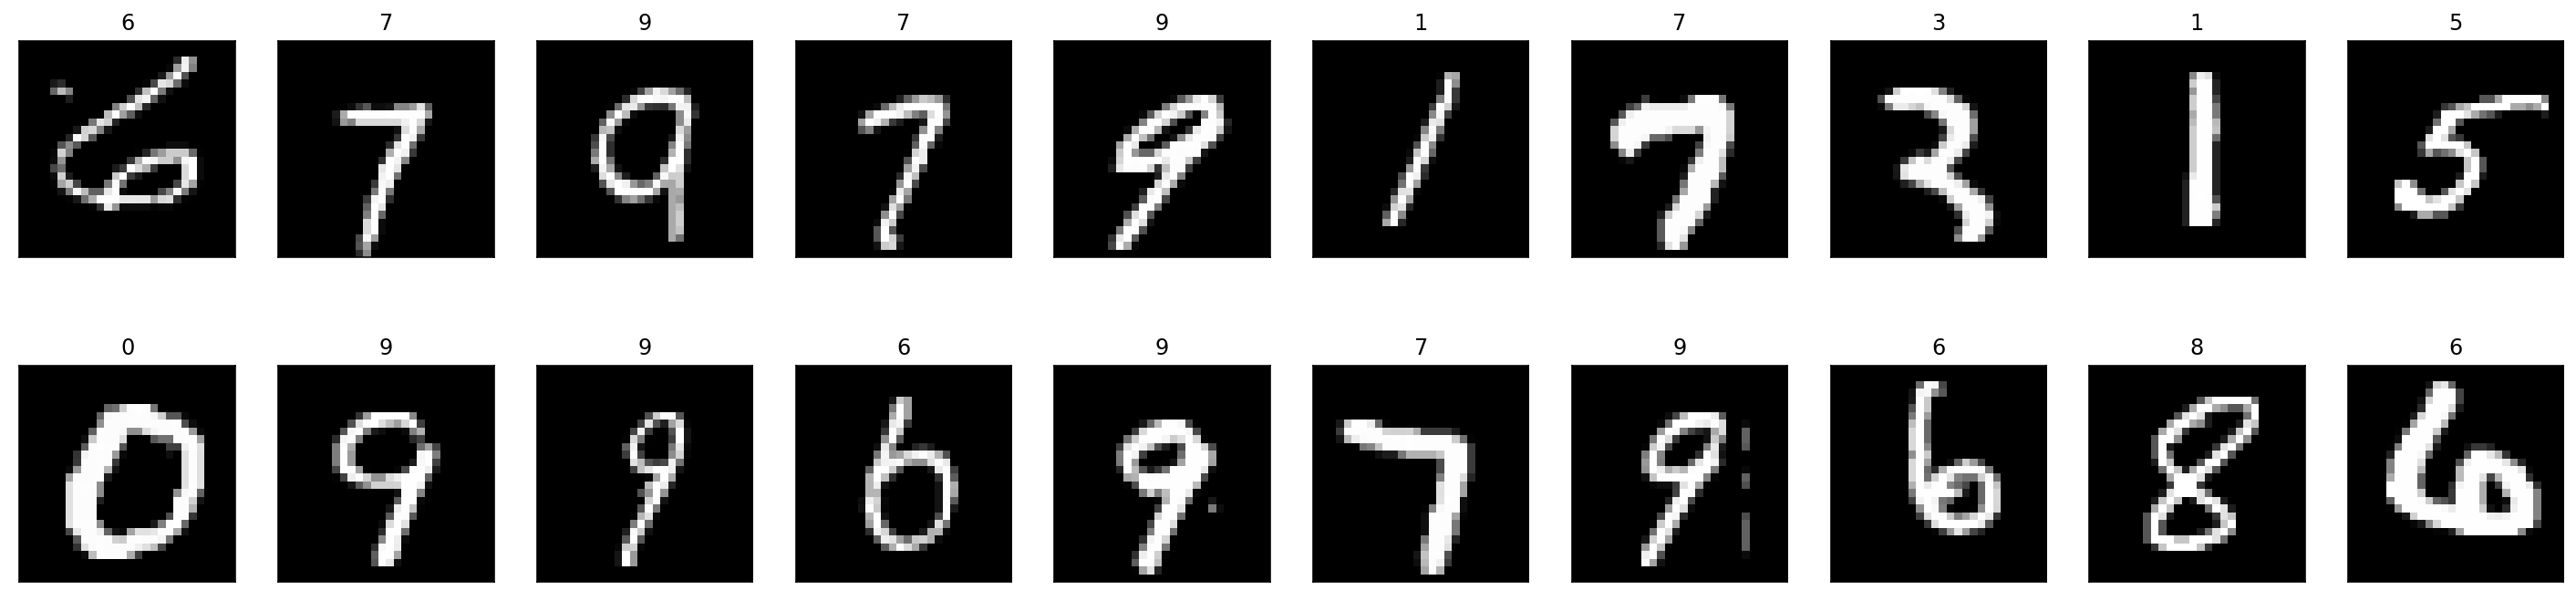

In [8]:
fig = plt.figure(figsize=(25,6))
for idx in range(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    # .item() gets the value contained in a Tensor
    ax.set_title(str(label[idx].item()))

In [9]:
classes = ['0','1','2','3','4','5','6','7','8','9']

In [10]:
images[0].shape

(1, 28, 28)

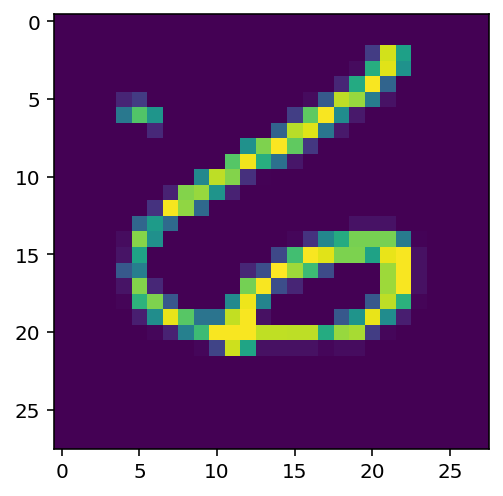

In [11]:
plt.imshow(images[0].squeeze())


In [12]:
from torch import nn, optim
import torch.nn.functional as F

In [13]:
class MNIST(nn.Module):
    def __init__(self):
        super(MNIST, self).__init__()  # Indicates that the MNIST class inherits properties from nn.Module.
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = F.log_softmax(self.fc3(x))
        
        return x

In [14]:
class ConvMNIST(nn.Module):
    def __init__(self):
        super(ConvMNIST, self).__init__()  # Indicates that the MNIST class inherits properties from nn.Module.
        
        self.conv1 = nn.Conv2d(1,12,3,1,1)
        self.conv2 = nn.Conv2d(12,24,3,1,1)
        self.fc3 = nn.Linear(24*28*28,10)
        
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self,x):
        
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.dropout(F.relu(self.conv2(x)))
        x = x.view(-1,24*28*28)
        x = F.log_softmax(self.fc3(x))
        
        return x

In [50]:
model = ConvMNIST()
criterion = nn.NLLLoss()
optimiser = optim.SGD(model.parameters(),lr=0.001)

In [58]:
model

ConvMNIST(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc3): Linear(in_features=18816, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [51]:
epochs = 10
train_losses = []
valid_losses = []
valid_loss_min = np.Inf

for e in range(epochs):
    batch_loss = 0
    valid_loss = 0
    for images, labels in trainloader:
        output = model(images)
        loss = criterion(output,labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        batch_loss += loss.item()
    with torch.no_grad():
        model.eval()
        for images, labels in validloader:
            output = model(images)
            loss = criterion(output,labels)
            valid_loss +=loss.item()
            
            probs = torch.exp(output)
            _, classes = torch.topk(probs, k=1, dim=1)
            equals = classes == labels.view(*classes.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            
    train_losses.append(batch_loss/len(trainloader))
    valid_losses.append(valid_loss/len(validloader))
    print(f"Training loss: {batch_loss/len(trainloader)}, Validation loss: {valid_loss/len(validloader)}")
    print(f"Accuracy (Validation): {accuracy.item()*100}%")
    
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased from {valid_loss_min} to {valid_loss/len(validloader)}. Saving the model")
        valid_loss_min = valid_loss/len(validloader)
    model.train()

/home/nagaraj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Training loss: 1.436545520822207, Validation loss: 0.5212756144873639
Accuracy (Validation): 84.375%
Validation loss decreased from inf to 0.5212756144873639. Saving the model
Training loss: 0.49248331729571027, Validation loss: 0.4109815816454431
Accuracy (Validation): 87.5%
Training loss: 0.43668474147717157, Validation loss: 0.36744371896728556
Accuracy (Validation): 81.25%
Training loss: 0.41446173512935636, Validation loss: 0.34941313982485456
Accuracy (Validation): 87.5%
Training loss: 0.3983787030180295, Validation loss: 0.36124531639383195
Accuracy (Validation): 96.875%
Training loss: 0.3881079215804736, Validation loss: 0.3251420946276568
Accuracy (Validation): 93.75%
Training loss: 0.37879772585630417, Validation loss: 0.3267284676511871
Accuracy (Validation): 93.75%
Training loss: 0.3652379322052002, Validation loss: 0.3182966025110255
Accuracy (Validation): 93.75%
Training loss: 0.3588911335468292, Validation loss: 0.31486033755255505
Accuracy (Validation): 90.625%
Training

In [55]:
import os
os.getcwd()
path = '/home/nagaraj/Desktop/OpenCV Projects/Digit recognizer/mnist_model.pth'

In [56]:
# Saving the model
torch.save(model, path)

/home/nagaraj/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvMNIST. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nagaraj/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nagaraj/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nagaraj/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + "

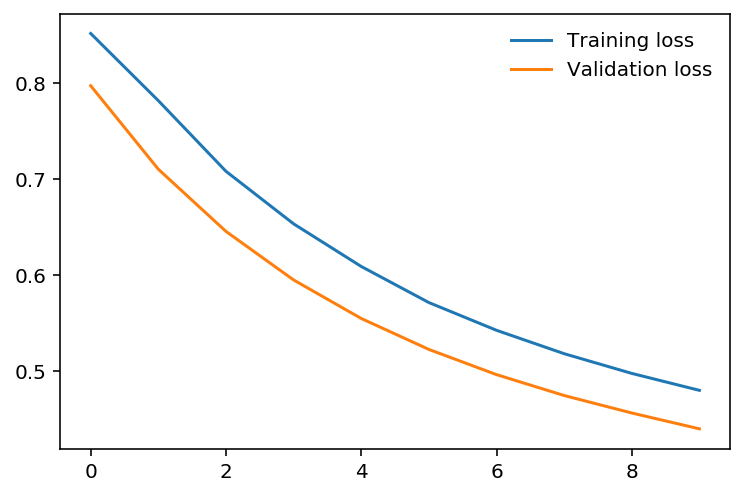

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [52]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

test_loss = 0
accuracy = 0
for inputs, labels in testloader:
    #inputs = inputs.view(inputs.shape[0],-1)
    
    output = model(inputs)
    loss = criterion(output,labels)
    
    test_loss +=loss.item()
            
    probs = torch.exp(output)
    _, classes = torch.topk(probs, k=1, dim=1)
    equals = classes == labels.view(*classes.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(testloader)
print(f"Test Loss: {test_loss}, Accuracy: {(accuracy/len(testloader))*100}%")
print(class_correct)
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/home/nagaraj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Test Loss: 0.34190222095389655, Accuracy: 89.77906036376953%
[960.0, 1107.0, 851.0, 954.0, 913.0, 708.0, 896.0, 904.0, 794.0, 889.0]
Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1: 97% (1107/1135)
Test Accuracy of     2: 82% (851/1032)
Test Accuracy of     3: 94% (954/1010)
Test Accuracy of     4: 92% (913/982)
Test Accuracy of     5: 79% (708/892)
Test Accuracy of     6: 93% (896/958)
Test Accuracy of     7: 87% (904/1028)
Test Accuracy of     8: 81% (794/974)
Test Accuracy of     9: 88% (889/1009)

Test Accuracy (Overall): 89% (8976/10000)


Predicted class 1
tensor(1)
tensor(1)


/home/nagaraj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


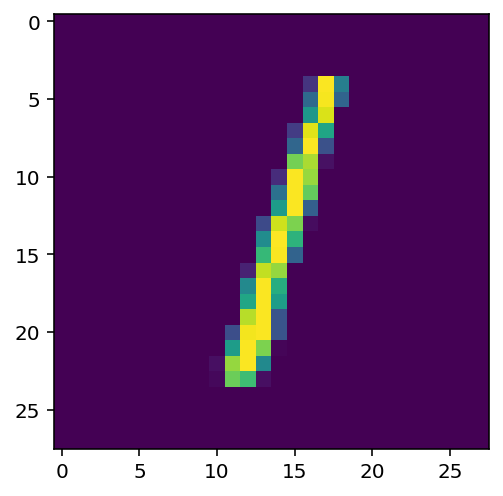

In [11]:
# Passing a single image
data = iter(testloader)
img, label = data.next()
img = img[2].squeeze()

out = model(img.view(1,784))

prob = torch.exp(out)
value, index = torch.topk(prob, k=1,dim=1)

plt.imshow(img)
print(f"Predicted class {classes[index[0][0]]}")
print(label[2])
print(index[0][0])

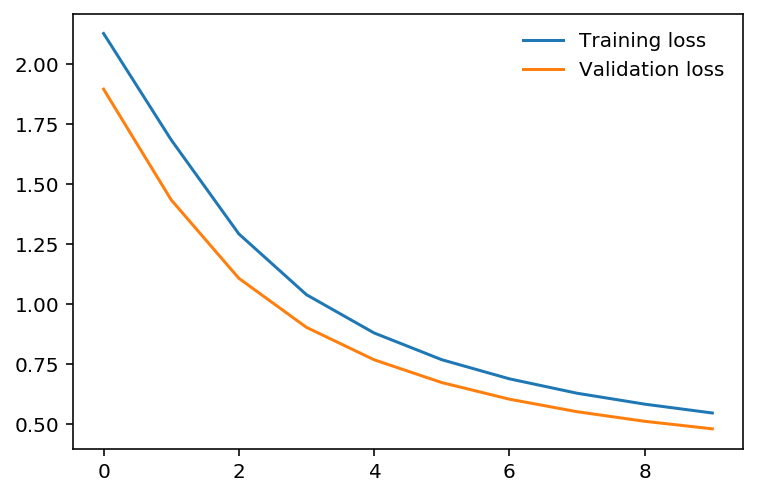

In [12]:
# Losses with regularization (dropout)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)